In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
decimation_data = pd.read_csv("Decimation.csv")
pti_data = pd.read_csv("PTI_Inversion.csv")

# DC Values

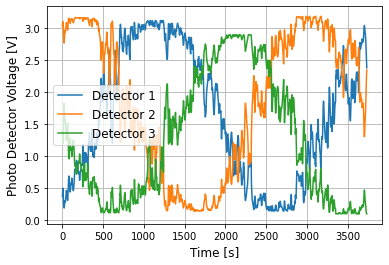

In [3]:
time = np.arange(len(decimation_data["DC1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data[f"DC{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("DC.pdf")

# RMS Values

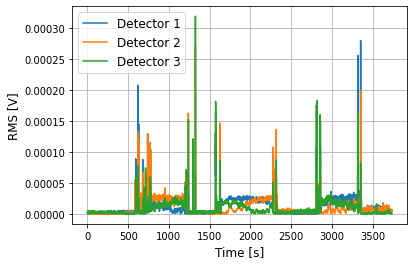

In [4]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.sqrt(decimation_data[f"X{channel}"] ** 2 + decimation_data[f"Y{channel}"] ** 2), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("RMS.pdf")

# Response Phases

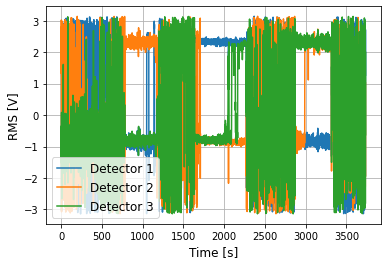

In [5]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.arctan2(decimation_data[f"Y{channel}"], decimation_data[f"X{channel}"]), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("RMS.pdf")

# PTI Signal

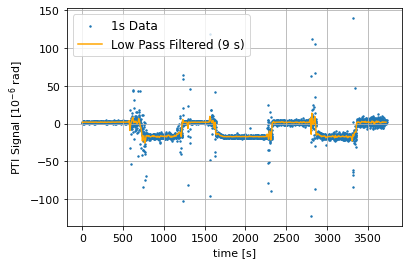

In [6]:
pti_mean = np.mean(np.array(pti_data["PTI Signal"]).reshape(-1, 9), axis=1)
time_mean = np.arange(pti_mean.size)
time_mean *= 9
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, -pti_data["PTI Signal"] * 1e6, s=2, label="1s Data")
plt.plot(time_mean, -pti_mean * 1e6, label="Low Pass Filtered (9 s)", color="orange")
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.legend(fontsize=12)
plt.ylabel("PTI Signal [$10^{-6}$ rad]", fontsize=11)
plt.savefig("pti.pdf", dpi=400, bbox_inches="tight")

# Interferometric Phase

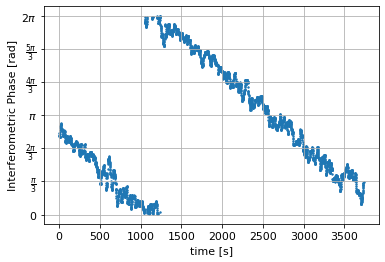

In [7]:
phases = pti_data["Interferometric Phase"].to_numpy()
phases[np.where(phases < 0)] += 2 * np.pi
_, ax = plt.subplots()
plt.yticks([0, np.pi / 3, 2 / 3 * np.pi, np.pi, 4 * np.pi / 3, 5 * np.pi / 3, 2 * np.pi],
           ['$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$\frac{4\pi}{3}$', r'$\frac{5\pi}{3}$', r'$2\pi$'])
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, phases, s=2)
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.ylabel("Interferometric Phase [rad]", fontsize=11)
plt.savefig("phase.pdf", dpi=400, bbox_inches="tight")

# Automatic Phase Scan

### Distribution of the interferometric phases

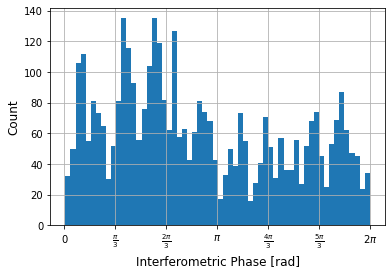

In [8]:
plt.hist(phases, bins=60)
plt.grid()
plt.xlabel("Interferometric Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, np.pi / 3, 2 / 3 * np.pi, np.pi, 4 * np.pi / 3, 5 * np.pi / 3, 2 * np.pi],
           ['$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$\frac{4\pi}{3}$', r'$\frac{5\pi}{3}$', r'$2\pi$'])
plt.show()

The interferometric phase shows the trend to a uniform distribution. However, it seems like that their exist still interferometric phases
which have a higher occurrence than others.

### Basic Idea of Algorithm
Formally we represent the phases as a set of multi-sets. Therefor we discretize the range 0 to $2\pi$ into $n$ different values (basing on the histogram above it may be more useful to choice no equal steps). Formally we obtain a sequence $$a_i = \frac{2 \pi}{n}i$$
If it holds for a given phase $\varphi$ the following $$a_i \le \varphi < a_{i+1}$$ then we put $\varphi$ into the $i$-th multi-set. While every multiset is not empty we can calculate output phases with exactly one element of every multi set.

We can implement this by using a directed Graph where node $v_i$ represents $a_i$. Every child of node $v_i$ (and there children) is a measured interferometric phase. We can calculate the output phases iff a BFS counts exactly $n$ nodes. If the result is less than $n$ we are still missing phases to calculate the output phases.

<center>
    <img src="graph.png">

In the figure above a possible graph for the phases is shown.
</center>

<center>
<img src="graph_dfs.png">

In the figure above a possible graph for the phases after a DFS is shown.
    </center>

In [102]:
import networkx as nx

In [280]:
G = nx.Graph()

In [281]:
n = 5
for i in range(n):
    G.add_node(round(2 * np.pi / n * i, 2))

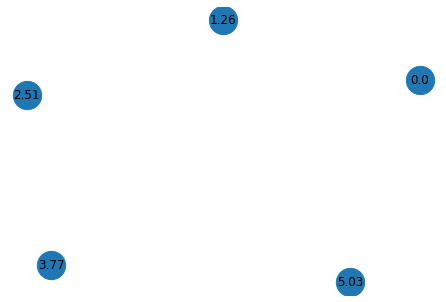

In [282]:
nx.draw(G, with_labels=True, node_size=800)

In [283]:
j = 0
for phase in phases:
    if j > 10:
        break
    i = int(n * phase / (2 * np.pi))
    G.add_edge(round(phase, 2), list(G.nodes())[i])
    j += 1

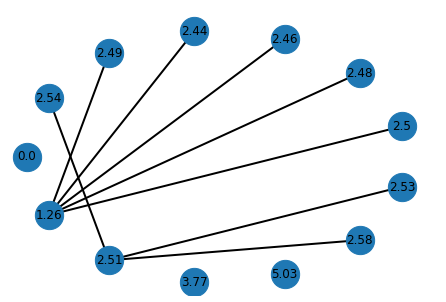

In [285]:
nx.draw_shell(G, with_labels=True, node_size=800, width=2)

The figure shows that the model works: every node is ordered to it's best-fit value. Every node $vi$ of $a_i$ represents the root of a tree now. Hence we have a forest. Output phases can be calculated if the output degree of every node $v_i$ is at least 1.